# Exploring JL's Survey Data

First we import the libraries we klnow we're going to use.

1. Pandas is a dataframe library, think of holding data in an excel table
2. Pomegranate is a probabilistic graphical model library (for Bayesian Networks)
3. networkx is for analysing and visualising graphs
4. matplotlib is a plotting lib
5. pylab likewise
6. seaborn, likewise again
7. Statsmodels- pretty much what it says on the tin, a stats package I used for Ordinary Least Squares Regression

In [96]:
import pandas as pd
from pomegranate import BayesianNetwork
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import statsmodels.api as sm

Next I import the data itself, and cast the column headers as strings (makes using other packages easier)

In [31]:
df = pd.read_excel("TEST DATA ANALYSIS.xlsx")
df.columns = [str(x) for x in list(df.columns)]

YHour data was not formatted nicely, note the spaces before and after. Also I converted the ordinal data into something more tractable for analysis.  This is a bit naughty, and would be frowned upon in some instances, but the 1-5 scale is implcitly continuous so felt acceptable.  NB scaling to between 0 and 1 is generally good practice as it ensures you're comparing a like for like across data (and if you were using other machine learning techniques it's near mandatory)

In [117]:
df = df.replace("Strongly Agree", 1)
df = df.replace("Agree", 0.75)
df = df.replace("Neutral", 0.5)
df = df.replace("Disagree", 0.25)
df = df.replace("Strongly Disagree", 0)

df = df.replace("Very Satisfied ", 1)
df = df.replace("Satisfied       ", 0.75)
df = df.replace(" Neither satisfied nor dissatisfied   ", 0.5)
df = df.replace("Dissatisfied    ", 0.25)
df = df.replace("Very dissatisfied", 0)

df = df.replace("Always", 1)
df = df.replace("Frequently ", 0.66)
df = df.replace("Sometimes", 0.33)
df = df.replace("Never ", 0)

df = df.replace("Excellent", 5)
df = df.replace("Good", 0.75)
df = df.replace("OK", 0.5)
df = df.replace("Bad", 0.25)
df = df.replace("Terrible", 0)

df = df.replace("Yes", 1)
df = df.replace("No", 0)

df.head()

,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.1,...,2.5,2.6,2.7,2.8,2.9,2.1.1,6,9,12,13
1,1.00,0.00,0.25,0.75,0.5,0.50,0.75,0.5,0.50,0.75,...,0.75,0.75,1.00,0.75,0.25,0.25,1.00,0.50,0.0,0
2,1.00,0.25,0.25,0.25,0.0,0.25,0.25,0.0,0.00,0.50,...,0.00,0.00,0.00,0.75,0.25,0.00,0.33,0.00,1.0,"Yes, m/e"
3,0.25,0.50,0.00,0.25,0.0,0.00,0.00,0.5,0.25,0.00,...,0.00,0.50,0.00,0.00,0.00,0.25,0.66,0.25,1.0,"Yes, m/e"
4,1.00,0.75,0.25,0.75,0.5,0.50,1.00,1.0,0.50,0.75,...,1.00,0.75,0.75,0.75,0.50,1.00,1.00,0.50,1.0,"Yes, m/e"
5,1.00,0.50,0.00,0.50,0.5,0.50,0.25,0.5,0.50,0.00,...,0.00,0.50,0.00,0.25,0.50,0.00,0.66,0.25,1.0,Other


Creating the input data for the modelling here.  y is the target, and X is the matrix of input data, so I dropped the y column (NB I dropped '13' as it wasn't really clear what I should convert it to and I was feelign lazy.  Will be easy enough to add it in and re-run) from the dataframe and the created the X data.

In [145]:
df = df.dropna()

y_1_9 = df["1.9"]
X_1_9 = df.drop(["1.9","13"], axis=1)

y_1_6 = df["1.6"]
X_1_6 = df.drop(["1.6","13"], axis=1)

y_1_4 = df["1.4"]
X_1_4 = df.drop(["1.4","13"], axis=1)

y_12 = df["12"]
X_12 = df.drop(["12","13"], axis=1)

X = df.drop("13", axis=1)


We're all set...

## Initial Data Analysis

So, having imported and cleaned the data we can do some analysis.  First up is a covariance matrix, to get a sense of any colinearity within the data. This is best practice here, and makes sure we don't end up with any BS conclusions from the data

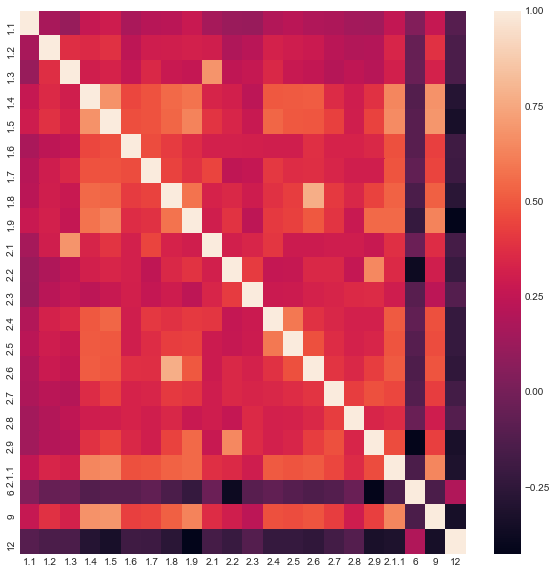

In [119]:
plt.figure(figsize=(10,10)) 
sns.heatmap(df.corr())

The good news is that there's nothing too egregious in there (i.e. one variable almost perfectly predicts another, note that 12 predicts 12, 1.1 predicts 1.1 etc. and hence is the peachy colour) so we can attack it with regression models with some comfort.  

It's also a good idea to do a box and whisker plot, to get a sense of the nature of the data (i.e. the means, the distributions etc.):

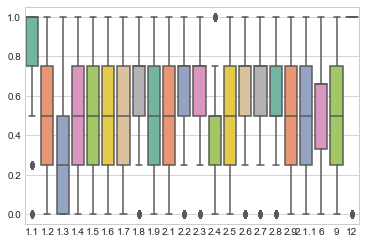

In [120]:
ax = sns.boxplot(data=df, orient="v", palette="Set2")

Looks pretty good, with the possible exception of variable 1.1. which is very high, though still uses the whole range

## Regression Analysis

At it's heart this is jsut dfrawing a best fit line, but a best fit over multiple planes.  The task behind it is called Ordinaryu Least Squares Regression, where the squared model errors (i.e. the distance from the proposed line, squared to make the positive and penalise the errors that are very big) is minimised.

The statsmodels package is a good one, but by no means the only one out there.  IT's functionality and output mirror that of other data analysis software like SPSS, R, SAS etc.

Key features to look at are the 

1. R squared value, which describes the amount of variance of the target/ dependent variable that is described by the input data data.  In you case this hovers aroun 0.85, pretty damn good

2. The coef(ficient), which describes tha extent of the realtionship between the dependent and respective input variable and 

3. The P>|t| value, if it's less than 0.05 you're in good shape, you'd say you have a 95% prob of rejected the null hypothsesis (that is that say 1.1 has no bearing on 1.9)

The rest of the bits are interesting, but not critical

### Target Variable 1.9

In [126]:
model = sm.OLS(y_1_9, X_1_9)
 
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    1.9   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     865.5
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        09:31:45   Log-Likelihood:                 633.88
No. Observations:                2349   AIC:                            -1226.
Df Residuals:                    2328   BIC:                            -1105.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1.1            0.1283      0.019      6.916      0.000       0.092       0.165
1.2            0.0204      0.015      1.405      0.160      -0.008       0.049
1.3           -0.0110      0.018     -0.611      0.542      -0.046       0.024
1.4            0.0813      0.020      4.005      0.000       0.041       0.121
1.5            0.1729      0.020      8.436      0.000       0.133       0.213
1.6           -0.0259      0.016     -1.596      0.111      -0.058       0.006
1.7           -0.0168      0.017     -0.996      0.319      -0.050       0.016
1.8            0.2214      0.023      9.474      0.000       0.176       0.267
2.1           -0.0036      0.019     -0.187      0.851      -0.042       0.034
2.2            0.0144      0.020      0.725      0.469      -0.025       0.053
2.3           -0.0340      0.019     -1.811      0.070      -0.071       0.003
2.4           -0.0046      0.020     -0.230      0.818      -0.044       0.034
2.5            0.0297      0.018      1.634      0.102      -0.006       0.065
2.6           -0.0236      0.024     -0.978      0.328      -0.071       0.024
2.7           -0.0085      0.017     -0.493      0.622      -0.042       0.025
2.8           -0.0181      0.022     -0.829      0.407      -0.061       0.025
2.9            0.2297      0.021     11.075      0.000       0.189       0.270
2.1.1          0.0049      0.019      0.254      0.800      -0.033       0.043
6             -0.0161      0.013     -1.201      0.230      -0.042       0.010
9              0.2179      0.023      9.356      0.000       0.172       0.264
12            -0.0972      0.010    -10.017      0.000      -0.116      -0.078
==============================================================================
Omnibus:                       35.075   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.703
Skew:                           0.171   Prob(JB):                     1.61e-11
Kurtosis:                       3.625   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Remember the p value of 0.05 is the standard approach, meaning the data is only  likely to give you a false positive statistical correlation 1 in 20 times (i.e. 1/20 = 0.05).  This minimises type I errors, i.e. false positives, but can mean you miss some real correaltions, (the false negatives, type II errors).  Hence things that are very near 0.05 might actually be wrong.  Good news is your data looks pretty reliable

Also remember that the coefficient is the amount that the target variable (in this case 1.9) changes with the variable in question.  So 1.9 goes up by 0.21 (approximately the jump from ok to good, good to excellent etc.) and is statistically sig as its p value is 0.000.  Conversely 1.9 goes down as 12 goes up, by c. 0.1, and is statistically sig.  

### Target Variable 1.6

In [49]:
model = sm.OLS(y_1_6, X_1_6)
 
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    1.6   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     641.1
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        19:21:27   Log-Likelihood:                 56.010
No. Observations:                2349   AIC:                            -70.02
Df Residuals:                    2328   BIC:                             50.98
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1.1            0.0132      0.024      0.552      0.581      -0.034       0.060
1.2           -0.0085      0.019     -0.459      0.646      -0.045       0.028
1.3            0.0146      0.023      0.634      0.526      -0.031       0.060
1.4            0.0939      0.025      3.699      0.000       0.044       0.144
1.5            0.1468      0.026      5.659      0.000       0.096       0.198
1.7            0.2168      0.021     10.297      0.000       0.176       0.258
1.8            0.0724      0.030      2.379      0.017       0.013       0.132
1.9           -0.0398      0.026     -1.516      0.130      -0.091       0.012
2.1           -0.0002      0.025     -0.007      0.994      -0.049       0.048
2.2            0.0786      0.025      3.104      0.002       0.029       0.128
2.3            0.1141      0.024      4.775      0.000       0.067       0.161
2.4           -0.0687      0.025     -2.709      0.007      -0.118      -0.019
2.5           -0.0389      0.023     -1.673      0.095      -0.085       0.007
2.6            0.0191      0.031      0.618      0.537      -0.041       0.080
2.7            0.0036      0.022      0.167      0.868      -0.039       0.046
2.8            0.1265      0.028      4.558      0.000       0.072       0.181
2.9            0.0293      0.027      1.076      0.282      -0.024       0.083
2.1.1          0.1301      0.024      5.325      0.000       0.082       0.178
6              0.0131      0.017      0.763      0.446      -0.021       0.047
9              0.0110      0.006      1.749      0.080      -0.001       0.023
12             0.0127      0.013      0.999      0.318      -0.012       0.038
==============================================================================
Omnibus:                       25.919   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.695
Skew:                          -0.236   Prob(JB):                     2.63e-06
Kurtosis:                       2.799   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Target Variable 1.4

In [50]:
model = sm.OLS(y_1_4, X_1_4)
 
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    1.4   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     753.6
Date:                Wed, 15 May 2019   Prob (F-statistic):               0.00
Time:                        19:21:39   Log-Likelihood:                 540.07
No. Observations:                2349   AIC:                            -1038.
Df Residuals:                    2328   BIC:                            -917.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1.1            0.0022      0.019      0.113      0.910      -0.036       0.040
1.2            0.0347      0.015      2.306      0.021       0.005       0.064
1.3            0.0345      0.019      1.841      0.066      -0.002       0.071
1.5            0.2563      0.021     12.454      0.000       0.216       0.297
1.6            0.0622      0.017      3.699      0.000       0.029       0.095
1.7            0.0870      0.017      4.992      0.000       0.053       0.121
1.8            0.0918      0.025      3.713      0.000       0.043       0.140
1.9            0.1195      0.021      5.629      0.000       0.078       0.161
2.1           -0.0533      0.020     -2.657      0.008      -0.093      -0.014
2.2            0.0274      0.021      1.328      0.184      -0.013       0.068
2.3           -0.0585      0.020     -3.000      0.003      -0.097      -0.020
2.4            0.0668      0.021      3.239      0.001       0.026       0.107
2.5            0.0944      0.019      5.006      0.000       0.057       0.131
2.6            0.0507      0.025      2.019      0.044       0.001       0.100
2.7           -0.0364      0.018     -2.051      0.040      -0.071      -0.002
2.8           -0.0045      0.023     -0.198      0.843      -0.049       0.040
2.9           -0.0586      0.022     -2.649      0.008      -0.102      -0.015
2.1.1          0.1857      0.020      9.462      0.000       0.147       0.224
6             -0.0136      0.014     -0.979      0.328      -0.041       0.014
9              0.0292      0.005      5.736      0.000       0.019       0.039
12             0.0012      0.010      0.120      0.905      -0.019       0.022
==============================================================================
Omnibus:                       14.283   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.925
Skew:                           0.028   Prob(JB):                     4.71e-05
Kurtosis:                       3.448   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Target Variable 12

In [146]:
model = sm.OLS(y_12, X_12)
 
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    1.4   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     792.9
Date:                Thu, 16 May 2019   Prob (F-statistic):               0.00
Time:                        10:51:59   Log-Likelihood:                 592.28
No. Observations:                2349   AIC:                            -1143.
Df Residuals:                    2328   BIC:                            -1022.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1.1           -0.0185      0.019     -0.969      0.332      -0.056       0.019
1.2            0.0158      0.015      1.065      0.287      -0.013       0.045
1.3            0.0290      0.018      1.581      0.114      -0.007       0.065
1.5            0.2004      0.021      9.652      0.000       0.160       0.241
1.6            0.0560      0.016      3.401      0.001       0.024       0.088
1.7            0.0837      0.017      4.910      0.000       0.050       0.117
1.8            0.0828      0.024      3.426      0.001       0.035       0.130
1.9            0.0842      0.021      4.005      0.000       0.043       0.125
2.1           -0.0564      0.020     -2.872      0.004      -0.095      -0.018
2.2            0.0347      0.020      1.719      0.086      -0.005       0.074
2.3           -0.0491      0.019     -2.571      0.010      -0.087      -0.012
2.4            0.0595      0.020      2.946      0.003       0.020       0.099
2.5            0.0897      0.018      4.863      0.000       0.054       0.126
2.6            0.0433      0.025      1.764      0.078      -0.005       0.091
2.7           -0.0506      0.017     -2.902      0.004      -0.085      -0.016
2.8           -0.0038      0.022     -0.171      0.864      -0.047       0.040
2.9           -0.0589      0.022     -2.725      0.006      -0.101      -0.017
2.1.1          0.1543      0.019      7.946      0.000       0.116       0.192
6             -0.0112      0.014     -0.824      0.410      -0.038       0.015
9              0.2777      0.023     11.841      0.000       0.232       0.324
12             0.0006      0.010      0.063      0.950      -0.019       0.020
==============================================================================
Omnibus:                       27.597   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.473
Skew:                           0.024   Prob(JB):                     8.10e-11
Kurtosis:                       3.687   Cond. No.                         21.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Bayesian Networks

I like a Bayesian Network as you can get a sense of the relative independence of data from them and work out the "Markov Blankets", basically the chunks of variables that depend only on each other.  Pomegranate is a good package for this stuff, blisteringly quick and aside from a slightly odd syntax a pleasure to use.

The "Greedy" algorithm below just searches in a greedy fashion (that is making the best decision available at any given time) to construct a grpahical structure for the data set)

In [128]:
b_model = BayesianNetwork.from_samples(X, algorithm='greedy')
edges = convert_pom_2_nx(b_model.structure,df.columns)

Because pomegranate stores its graph structures in a weird fashion the function below was needed to translate.  Had it from some previous work fortunately

In [130]:
def printGraphs(edges):
    ''' Plots a visual representation of a list of networkx graphs
    
    Arguments:     
    edgeLst -- the graph that requires plotting
    title   -- the title of said graph
    
    Returns:
    n/a
    '''
    title = "test"
    G=nx.DiGraph()
    G.add_edges_from(edges, weight=1)  
    edge_labels=dict([((u,v,),d['weight'])
                     for u,v,d in G.edges(data=True)])
    node_labels = {node:node for node in G.nodes()}    
    red_edges   = []
    blue_nodes   = [('A')]
    edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]
    node_colors = ['red' if not node in blue_nodes else 'blue' for node in G.nodes()]
    pos = nx.draw_kamada_kawai(G, iterations = 10000,labels=node_labels)
    #pylab.axes([.1,.1,.8,.7])
    #pylab.figtext(.5,.9,title, fontsize=18, ha='center')
    #pylab.figtext(.5,.85,G.edges(),fontsize=10,ha='center')
    #nx.draw_networkx(G,pos,node_color = node_colors,node_size=450,labels=node_labels,
    #         font_color='w',edge_labels=edge_labels,edge_color=edge_colors,
    #         edge_cmap=plt.cm.Reds)
    #filename = getResPath(timestr) +'\\'+ timestr + "_" + str(j) + "_" + title + ".png"
    #pylab.savefig(filename) 
    #colour the dags, green for correct, red for wrong amber for wrong direction
    pylab.show()
    
    pos = nx.draw_spring(G, iterations = 10000,labels=node_labels)
    pylab.show()

The graphs below are all the same, but laid out differently to ease viewing.  An arrow from one node to another signifies a causla relationship (or rather what looks like one).  So for example 2.1 is dictated by 1.3, and hence knowing 1.3 is kind of pointless if you know 2.1.

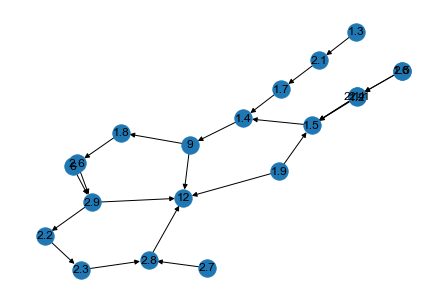

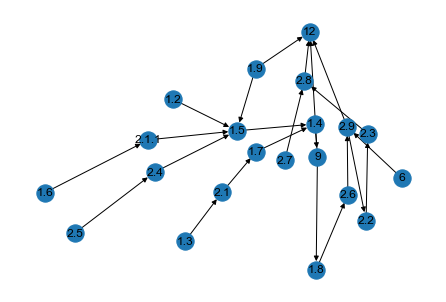

In [131]:
printGraphs(edges)

## Decision Trees

Thought I'd have a play with decision rees to round things off.  These can help intepret what's goig on in the data itself in a human readable form. They will mirror the outcomes of the OLS regresion, but can be more interpretable to people as they are rules based.  We can explore this further at another juncture

In [157]:
from sklearn.datasets import load_iris
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier(max_depth=3)
iris = load_iris()

y_1_6 = y_1_6.replace(0,0)
y_1_6 = y_1_6.replace(1,4)
y_1_6 = y_1_6.replace(0.25,1)
y_1_6 = y_1_6.replace(0.5,2)
y_1_6 = y_1_6.replace(0.75,3)


clf_dt.fit(X_1_6,y_1_6)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [158]:
from sklearn.tree import export_graphviz
export_graphviz(clf_dt, out_file='tree_limited.dot', feature_names = X_1_6.columns,
                class_names = [str(x) for x in y_1_6.unique()],
                rounded = True, proportion = False, precision = 2, filled = True)

In [159]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'



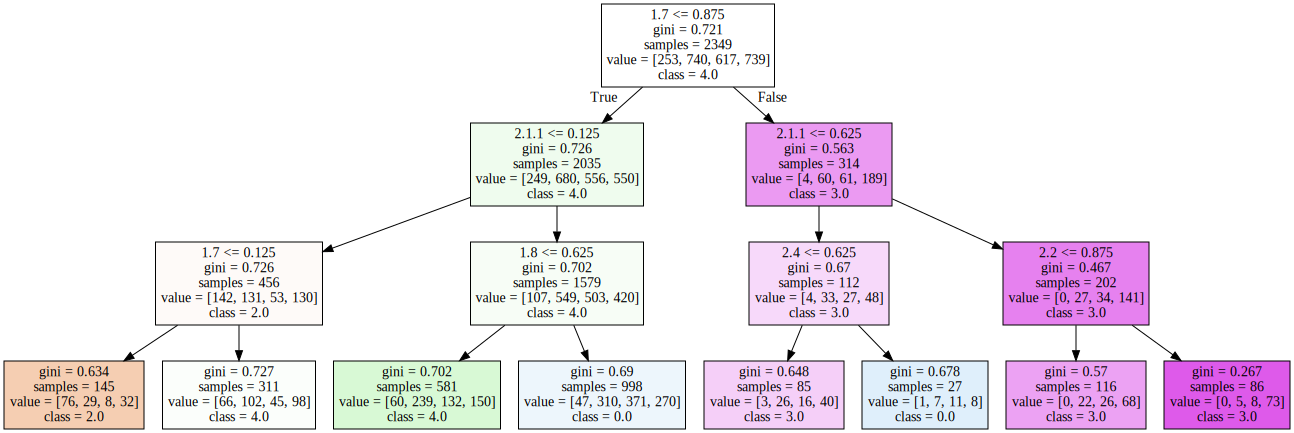

In [160]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(tree.export_graphviz(clf_dt, out_file=None
   , feature_names=X_1_6.columns, class_names=[str(x) for x in y_1_6.unique()] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))